In [1]:
import math
import pandas as pd
import numpy as np

from sklearn.metrics import auc , roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , Dense , Flatten , MaxPooling2D
from tensorflow.keras.layers import Dropout , BatchNormalization  , LeakyReLU , Activation 
from tensorflow.keras.callbacks import Callback , EarlyStopping , ReduceLROnPlateau 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

In [2]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [4]:
emotion_label_to_text = {0:'anger',1:'disgust',2:'fear',3:'happiness',4:'sadness',5:'surprise',6:'neutral'}

In [5]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

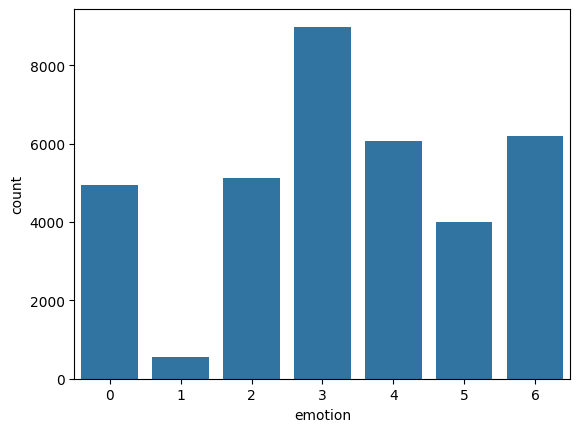

In [6]:
sns.countplot(x='emotion',data=df)
plt.show()

In [7]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

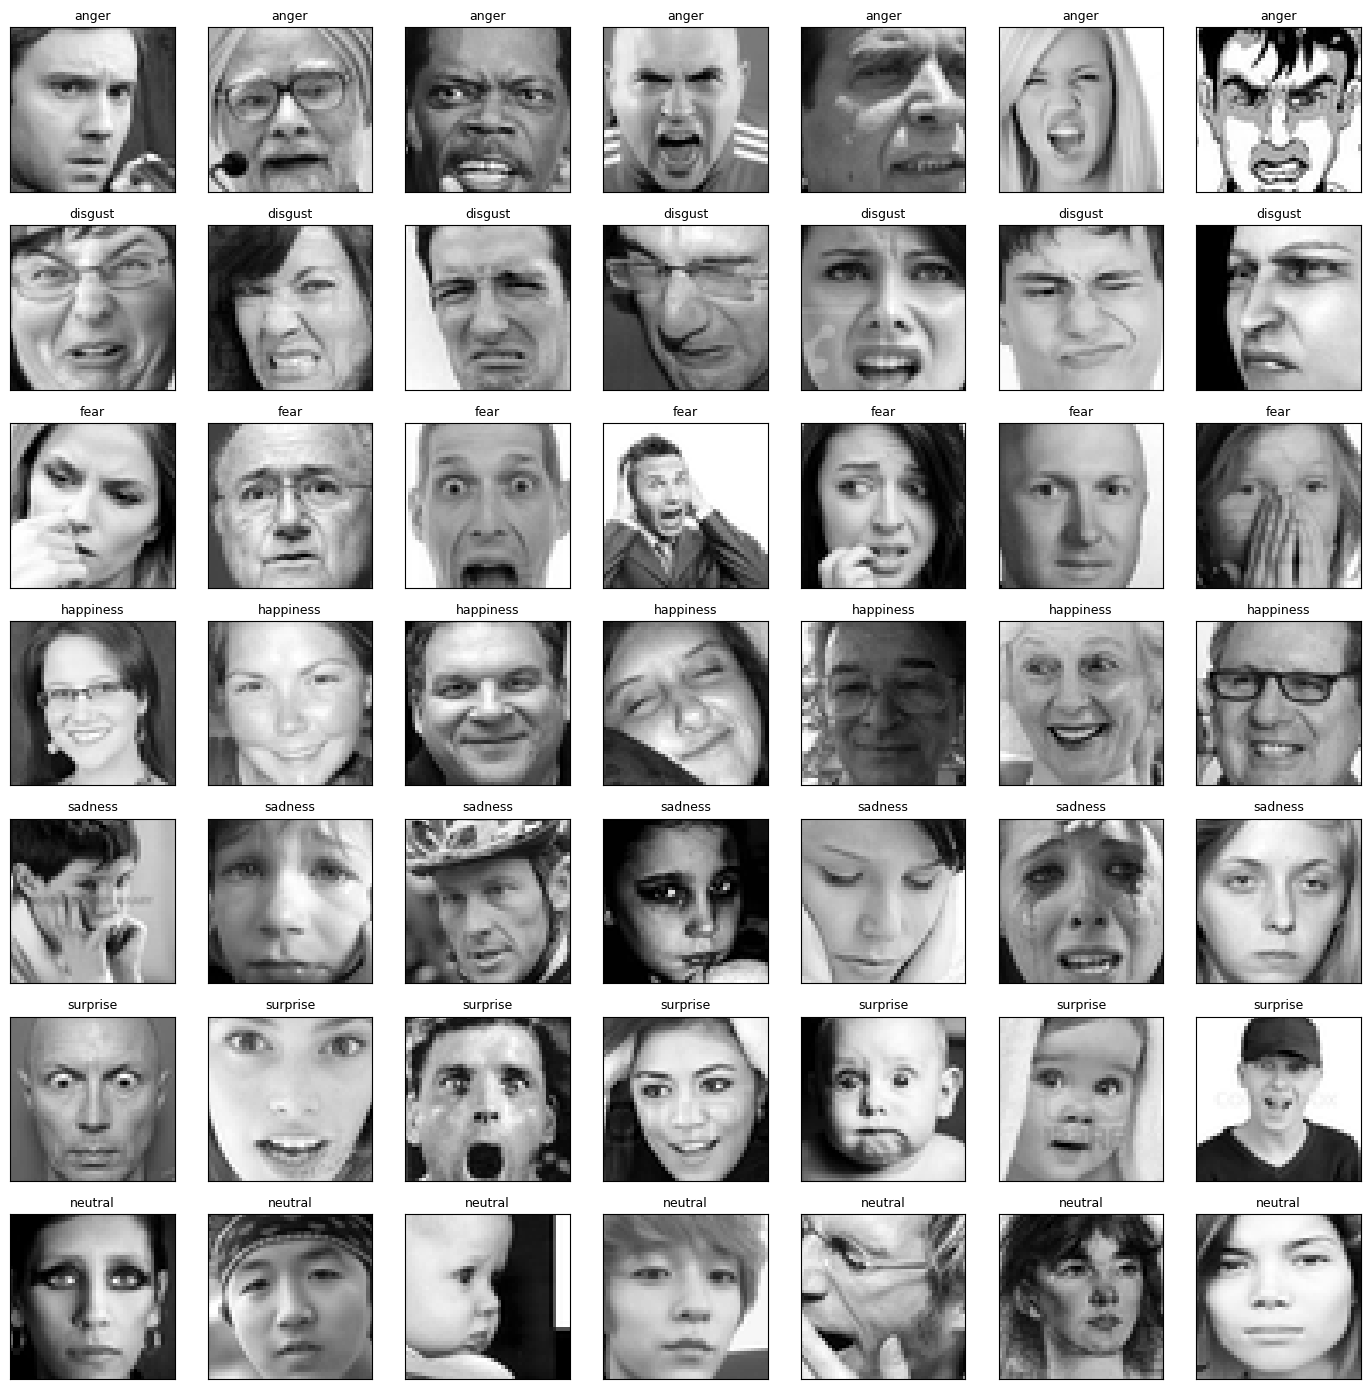

In [8]:
fig , axes  = plt.subplots(7,7 , figsize=(14,14))
k = 0
for lable , i  in enumerate(sorted(df.emotion.unique())):
    emotion_images = df[df.emotion == lable]
    for j in range (7):
        px = emotion_images.pixels.iloc[j]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')

        ax = axes[i,j]
        ax.imshow(px , cmap = 'grey')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[lable],fontsize=9)
plt.tight_layout()
plt.show()

In [9]:
INTEREST_LABLES = (3,4,6)

In [10]:
df = df[df.emotion.isin(INTEREST_LABLES)]
df.shape

(21264, 3)

In [11]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
img_array = np.stack(img_array , axis=0)
img_array=img_array/255

In [12]:
img_array.shape

(21264, 48, 48, 1)

In [13]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [14]:
le_name_mapping = dict(zip(le.classes_ , le.transform(le.classes_)))
print(le_name_mapping)

{np.int64(3): np.int64(0), np.int64(4): np.int64(1), np.int64(6): np.int64(2)}


In [15]:
X_train , X_test , y_train , y_valid = train_test_split(img_array , img_labels , stratify = img_labels , shuffle= True , test_size = 0.1 , random_state = 42)
X_train.shape, X_test.shape , y_train.shape , y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [16]:
img_width = X_train.shape[1]
img_height =X_train.shape[2]
img_depth  = X_train.shape[3]
num_classes = y_train.shape[1]

In [17]:
X_train = X_train / 255.
X_test = X_test / 255.

In [18]:
def build_net(optim):
    net = Sequential(name='DCNN')
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    return net
    

In [19]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [22]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]
model = build_net(optims[1]) 
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100


2026-02-21 18:24:58.032545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


598/598 ━━━━━━━━━━━━━━━━━━━━ 95s 154ms/step - accuracy: 0.3954 - loss: 1.3029 - val_accuracy: 0.4213 - val_loss: 1.0728 - learning_rate: 0.0010
Epoch 2/100
  1/598 ━━━━━━━━━━━━━━━━━━━━ 1:32 155ms/step - accuracy: 0.3438 - loss: 1.1204

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3438 - loss: 1.1204 - val_accuracy: 0.4137 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 93s 156ms/step - accuracy: 0.4740 - loss: 1.0334 - val_accuracy: 0.5811 - val_loss: 0.8845 - learning_rate: 0.0010
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4375 - loss: 1.0134 - val_accuracy: 0.5736 - val_loss: 0.8877 - learning_rate: 0.0010
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 96s 160ms/step - accuracy: 0.5370 - loss: 0.9398 - val_accuracy: 0.6225 - val_loss: 0.8090 - learning_rate: 0.0010
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4375 - loss: 0.8628 - val_accuracy: 0.6187 - val_loss: 0.8183 - learning_rate: 0.0010
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 108s 181ms/step - accuracy: 0.5952 - loss: 0.8390 - val_accuracy: 0.6253 - val_loss: 0.7578 - learning_rate: 0.0010
Epoch 8/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6562 - loss: 0.76

In [23]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

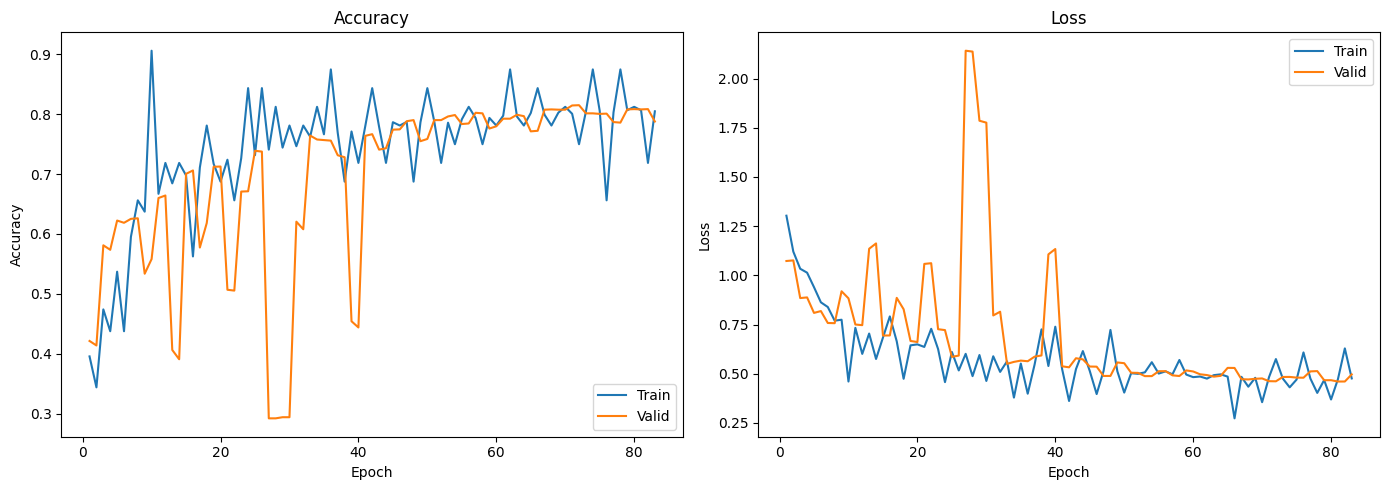

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Initialize the figure and axes for 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Create epoch index (safer than history.epoch)
epochs = range(1, len(history.history['accuracy']) + 1)

# 🔹 Accuracy Plot
sns.lineplot(x=epochs, y=history.history['accuracy'], ax=axes[0], label='Train')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], ax=axes[0], label='Valid')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')

# 🔹 Loss Plot
sns.lineplot(x=epochs, y=history.history['loss'], ax=axes[1], label='Train')
sns.lineplot(x=epochs, y=history.history['val_loss'], ax=axes[1], label='Valid')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.savefig('epoch_history_dcnn.png')
plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


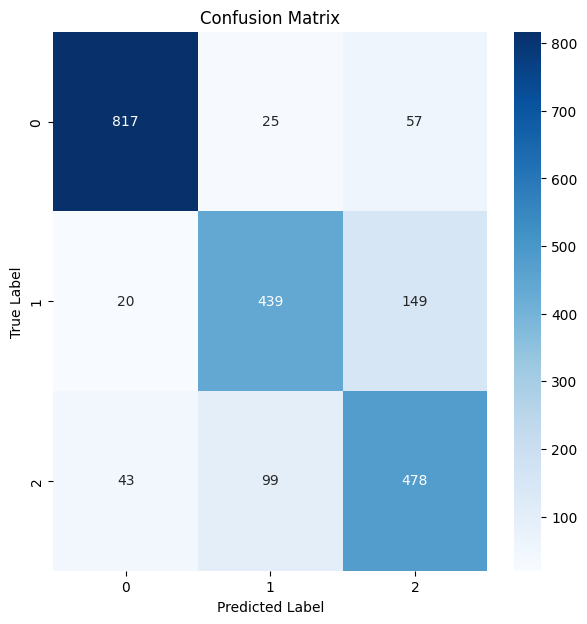

Total wrong validation predictions: 393




In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predictions and convert both true & predicted to standard labels (0 to 6)
yhat_valid_probs = model.predict(X_test)
yhat_valid_labels = np.argmax(yhat_valid_probs, axis=1)
y_true_labels = np.argmax(y_valid, axis=1)

# 2. Compute Confusion Matrix
cm = confusion_matrix(y_true_labels, yhat_valid_labels)

# 3. Plot it using Seaborn (which is already in your notebook)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("confusion_matrix_dcnn.png")
plt.show()

# 4. Calculate and print total wrong predictions
wrong_preds = np.sum(y_true_labels != yhat_valid_labels)
print(f'Total wrong validation predictions: {wrong_preds}\n\n')

In [34]:
from sklearn.metrics import classification_report
import numpy as np

# 1. Get predictions and convert to class integers
yhat_valid_probs = model.predict(X_test)
yhat_valid_classes = np.argmax(yhat_valid_probs, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

# 2. Define your emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# 3. Explicitly list the class indices (0 to 6)
all_classes = [0, 1, 2, 3, 4, 5, 6]

# 4. Generate the report with 'labels' and 'zero_division' added
report = classification_report(
    y_true_classes, 
    yhat_valid_classes, 
    labels=all_classes,           # 🔹 Tells it to expect 7 classes
    target_names=emotion_labels, 
    zero_division=0               # 🔹 Prevents warnings for missing classes
)

print("Classification Report:\n")
print(report)

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
Classification Report:

              precision    recall  f1-score   support

       Angry       0.93      0.91      0.92       899
     Disgust       0.78      0.72      0.75       608
        Fear       0.70      0.77      0.73       620
       Happy       0.00      0.00      0.00         0
         Sad       0.00      0.00      0.00         0
    Surprise       0.00      0.00      0.00         0
     Neutral       0.00      0.00      0.00         0

    accuracy                           0.82      2127
   macro avg       0.34      0.34      0.34      2127
weighted avg       0.82      0.82      0.82      2127



In [39]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


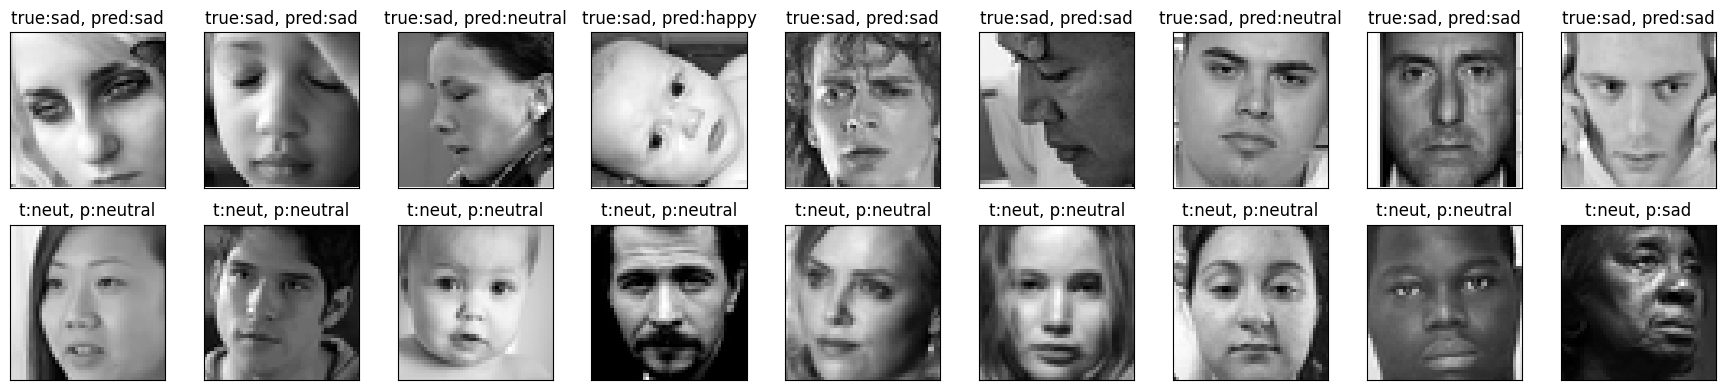

In [47]:

np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig =plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = plt.subplot(2, 9, i+1)
        sample_img = X_test[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")

        ax = plt.subplot(2, 9, i+10)
        sample_img = X_test[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")

        plt.tight_layout()